# Análise de agrupamentos em bases de compostos químicos: Detecção de moléculas anômalas

### Obtendo moléculas com 19 átomos

In [1]:
#Função que analisa se o arquivo xyz tem 19 átomos
def analisa_xyz(arquivo):
    
    with open(arquivo, "r") as arq:
        
        if int(arq.readline()) == 19: return True
        
        else: return False

In [2]:
#Função que retorna número de atomos e os atomos e coordenadas em um array
def ler_xyz(arquivo): 
    
    with open(arquivo) as arq:
        
        num_atomos = 0
        atomos = []
        coordenadas = []
        
        for num_linha, linha in enumerate(arq):
            
            #Obtém a quantidade de atomos
            if num_linha == 0: num_atomos = int(linha)
                
            #Condição para obter os atomos e coordenadas
            if num_linha >= 2 and num_linha < 2 + num_atomos:
                
                
                info = linha.replace("*^","e").split("\t")
                atomos.append(info[0])
                coordenadas.append(list(map(float, info[1:-1])))
            
            #Condição de obtenção dos smiles
            elif num_linha == num_atomos + 3:
                
                info = linha.replace("\n", "").split("\t")
                smiles = info[0]

    return smiles, num_atomos, atomos, coordenadas

### Laço para fazer a leitura

In [3]:
from glob import glob

In [5]:
smiles = []
dados = []

for mol in glob("QM9/*.xyz"):
    
    #Condição para obter os dados somente dos compostos com 19 átomos
    if analisa_xyz(mol):
        info = glob(mol)[0]
        
        smiles_aux, num_atomos, atomos, coordenadas = ler_xyz(mol)
        dados_aux = [atomos, coordenadas]
        
        smiles.append(smiles_aux)
        dados.append(dados_aux)


### Obtendo a quantidade de cada átomo

In [52]:
carbono = 0
hidrogenio = 0
oxigenio = 0
nitrogenio = 0
fluor = 0
for i in range(len(dados)):
    carbono += dados[i][0].count('C')
    hidrogenio += dados[i][0].count('H')
    oxigenio += dados[i][0].count('O')
    nitrogenio += dados[i][0].count('N')
    fluor += dados[i][0].count('F')
    

### Plotando a quantidade de cada átomo em porcentagem

In [75]:
carbono = (carbono/(19*len(dados)))*100
hidrogenio = (hidrogenio/(19*len(dados)))*100
oxigenio = (oxigenio/(19*len(dados)))*100
nitrogenio = (nitrogenio/(19*len(dados)))*100
fluor = (fluor/(19*len(dados)))*100

print('% carbono: {:.2f}'.format(carbono))
print('% hidrogenio: {:.2f}'.format(hidrogenio))
print('% oxigenio: {:.2f}'.format(oxigenio))
print('% nitrogenio: {:.2f}'.format(nitrogenio))
print('% fluor: {:.2f}'.format(fluor))

atomos = [carbono, hidrogenio, oxigenio, nitrogenio, fluor]
sigla = ['C', 'H', 'O', 'N', 'F']

% carbono: 35.64
% hidrogenio: 53.08
% oxigenio: 8.09
% nitrogenio: 3.19
% fluor: 0.01


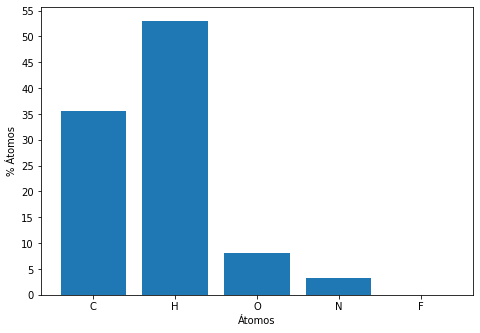

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yticks(np.arange(0, 60, 5))
ax.set_xlabel('Átomos')
ax.set_ylabel('% Átomos')
ax.bar(sigla,atomos)
plt.show()

### Obtendo a matriz de características (descritores) através dos SMILES

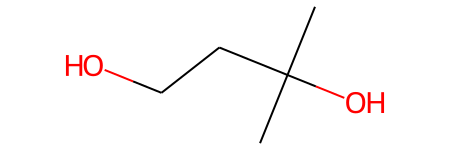

In [12]:
from rdkit import Chem
from mordred import Calculator, descriptors
Chem.MolFromSmiles(smiles[3])

In [7]:
mols = []
for mol in smiles:
    mols.append(Chem.MolFromSmiles(mol))
    
calc = Calculator()
calc.register(Calculator(descriptors, ignore_3D=True).descriptors)
feat = calc.pandas(mols)

100%|██████████| 18336/18336 [06:30<00:00, 46.90it/s]


In [8]:
Calculator(descriptors, ignore_3D=True).descriptors[:5]

(mordred.ABCIndex.ABCIndex(),
 mordred.ABCIndex.ABCGGIndex(),
 mordred.AcidBase.AcidicGroupCount(),
 mordred.AcidBase.BasicGroupCount(),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'))

### Tratando os dados

In [84]:
#Alterando valores não numéricos para NaN
feat = feat.apply(pd.to_numeric, errors='coerce')

#Eliminando coluna com valores NaN
feat = feat.dropna(how='any', axis=1)

#Criando dataframe com a variância de feat
var = feat.var(axis=0, numeric_only=True).to_frame()

#Lista com as features que teve variâncias iguais a 0
lista_var = list(var[(var.T == 0).any()].transpose())

#Remoção das features em feat
feat = feat.drop(lista_var, axis=1)

### Estandardização e utilização do PCA 

In [6]:
from sklearn import preprocessing
import numpy as np

In [87]:
#Estandardização dos dados
X_train = feat.to_numpy(dtype=float)
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [88]:
X_scaled

array([[-3.18743574, -3.06249151, -0.09271629, ..., -1.97278723,
         1.39193328, -1.70249638],
       [-3.18743574, -3.06249151, -0.09271629, ..., -1.97278723,
         1.39193328, -1.70249638],
       [-3.18743574, -3.06249151, -0.09271629, ..., -1.97278723,
         1.39193328, -1.70249638],
       ...,
       [ 1.95471209,  1.04757139, -0.09271629, ...,  1.93931538,
        -1.98533756, -1.63494603],
       [ 1.95471209,  1.04757139, -0.09271629, ...,  1.93931538,
        -1.98533756, -1.63494603],
       [ 2.68364492,  2.50811787, -0.09271629, ...,  3.14746472,
        -2.29236218, -2.1753488 ]])

In [89]:
from sklearn.decomposition import PCA

In [90]:
#Quantidade de componentes
comp = 200

#Utilizando pca para os dados
pca = PCA(n_components=comp)
X_pca = pca.fit_transform(X_scaled)

#Obtendo array de variância do pca
pca_var = pca.explained_variance_ratio_

X_pca.shape

(18336, 200)

### Filtrando os atributos para os que se somam 95% de variância

In [91]:
soma = 0

#Analisa a soma das variâncias que obtém o resultado acima de 95%
for i in range(comp):
    soma += pca_var[i]
    
    if soma > 0.95:
        break
    
#Atualiza a matriz de pca tendo como resultado somente os valores cuja variância somadas é maior do que 95%
X_pca = X_pca[:,0:i]
X_pca.shape

(18336, 59)

### Criando a matriz de adjacência e obtendo a rede com uma parcela dos dados

In [3]:
from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [177]:
#Função que retorna a matriz de adjacência
def matrizAdj(entrada, theta=0.79):
    matriz = entrada
    maximo = np.max(np.max(matriz))
    matriz[matriz == 0] = maximo
    matriz[:] = -(matriz/maximo)
    matriz = np.exp(matriz)
    matrizadj = np.where(matriz > theta, 1, 0)
    
    return matrizadj

In [180]:
#Matriz com a distância euclidiana
matriz = distance_matrix(X_pca, X_pca)

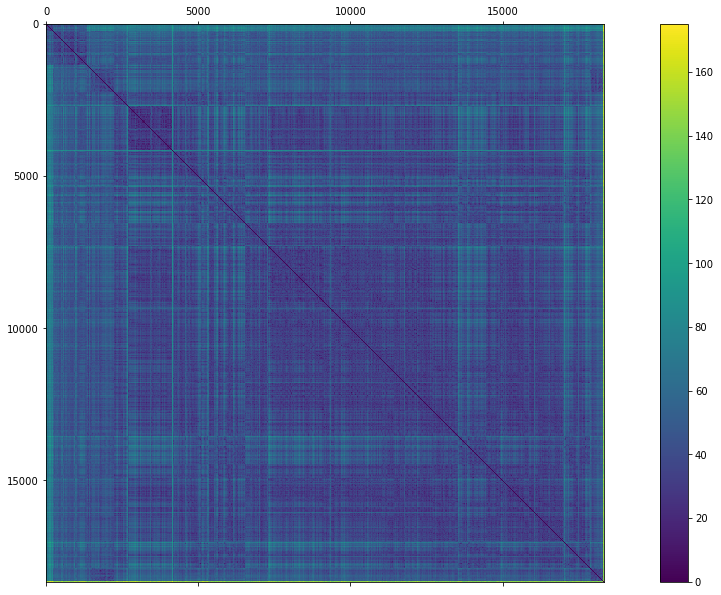

43.198481873303955


In [169]:
#Plot da matriz de distância
plt.figure(figsize=(20,10))
plt.matshow(matriz, fignum=1)
plt.colorbar()
plt.show()

#Média dos valores da matriz
print(np.average(matriz))

In [185]:
#Obtenção da matriz de adjacência
matrizadj = matrizAdj(matriz)

#Média dos valores da matriz
print(np.average(matrizadj))

0.48446550920532455


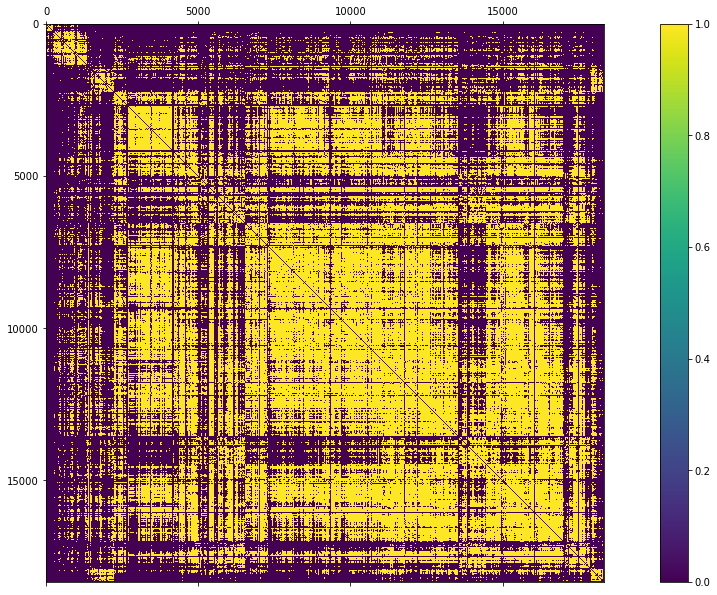

In [187]:
#Plot da matriz de adjacência
plt.figure(figsize=(20,10))
plt.matshow(matrizadj, fignum=1)
plt.colorbar()
plt.show()

In [114]:
#Obtenção da parcela da matriz de adjacência
parcela = matrizadj[0::15,0::15]
len(parcela)

1223

In [205]:
#Obtenção da rede
G = nx.from_numpy_matrix(parcela)

#Densidade da rede
print(nx.density(G))

0.4849923653702294


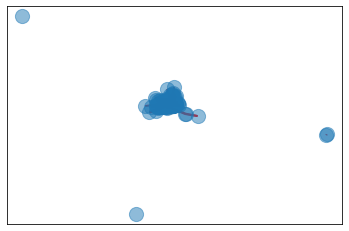

In [206]:
#Plot da rede obtida
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 200, alpha=0.5)
nx.draw_networkx_edges(G, pos, arrows=False, width = 2, edge_color = 'r')
plt.show()

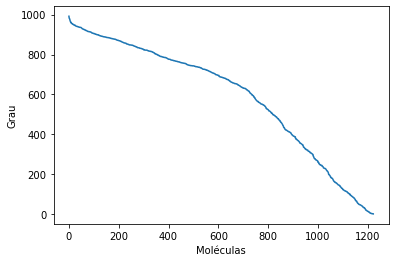

In [210]:
#Plot do grau de cada molécula
D = np.array(G.degree())
v = -np.sort(-D[:,1])
plt.xlabel('Moléculas')
plt.ylabel('Grau')
plt.plot(v)

In [2]:
#Obtenção das comunidades através do agrupamento
com = list(greedy_modularity_communities(G))
com_sorted = sorted(com)

#Lista com a quantidade de moléculas em cada comunidade
com_mol = [len(com_sorted[i]) for i in range(len(com_sorted))]
com_mol

[673, 546, 2, 1, 1]

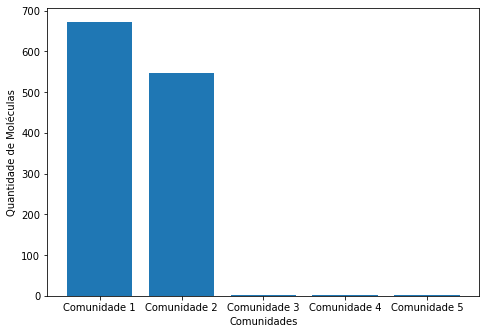

In [7]:
#Plot das comunidades com a quantidade de moléculas
comunidade = ['Comunidade 1','Comunidade 2','Comunidade 3','Comunidade 4','Comunidade 5']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yticks(np.arange(0, 800, 100))
ax.set_xlabel('Comunidades')
ax.set_ylabel('Quantidade de Moléculas')
ax.bar(comunidade,com_mol)
plt.show()